In [57]:
import random
"""
point[index, (x,y)]
layout[index, place]
"""
point=[]
layout=[]
filename = "./us_cities_1158_afterprocess.xyn.txt"

In [58]:
def prepare_data(select):
    point.clear()
    layout.clear()
    num = 1
    for line in open(filename):
        index, x, y = line.strip().split(" ")
        if int(index) % select == 0:
            point.extend([(num,(float(x),float(y)))])
            num = num + 1
    for i in range(len(point)):
        layout.append([i+1, random.randint(1,4), 0])
    # print(layout[:])
    # print(point[:])

In [59]:
prepare_data(5)

In [60]:
gapx, gapy = 5, 0.2
def getPos(i,m):
    pointx = point[i][1][0]
    pointy = point[i][1][1]
    # print(pointx, pointy)
    if m==1:
        return [(pointx,pointy),(pointx+gapx,pointy),(pointx+gapx,pointy+gapy),(pointx,pointy+gapy)]
    elif m==2:
        return [(pointx-gapx,pointy),(pointx,pointy),(pointx,pointy+gapy),(pointx-gapx,pointy+gapy)]
    elif m==3:
        return [(pointx-gapx,pointy-gapy),(pointx,pointy-gapy),(pointx,pointy),(pointx-gapx,pointy)]
    else:
        return [(pointx, pointy-gapy),(pointx+gapx,pointy-gapy),(pointx+gapx,pointy),(pointx,pointy)]
    
print(getPos(1,2))

[(68.8, 42.75), (73.8, 42.75), (73.8, 42.95), (68.8, 42.95)]


In [61]:
def inner(point, rec):
    if point[0] > rec[0][0] and point[1] > rec[0][1] and point[0] < rec[1][0] and point[1] > rec[1][1] and point[0] < rec[2][0] and point[1] < rec[2][1] and point[0] > rec[3][0] and point[1] < rec[3][1]:
        return True
    return False

In [62]:
def conflict(vect,i,j):
    """
    判断冲突
    """
    m = vect[i][1]
    n = vect[j][1]
    reci = getPos(i,m)
    recj = getPos(j,n)
    for i in range(len(reci)):
        if inner(reci[i], recj):
            return True
    return False


In [63]:
def costconfilct(vect):
    """
    计算每个点冲突
    """
    sum = 0
    for i in range(len(point)):
        temp = 0
        for j in range(len(point)):
            if i != j:
                if(conflict(vect,i,j)):
                    temp = temp + 1
        vect[i][2] = temp
        sum = sum + temp
    # print("conflict:"+str(sum))
    return sum

# print(costroad(layout))

In [64]:
def cost_function():
    res = 0
    for i in range(len(point)):
        res = res + layout[i][1]*0.1
    return res
print(cost_function())

58.30000000000002


In [65]:
def costroad(vect):
    """
    计算每个点cost
    """
    conflict = costconfilct(vect)
    conflict = 3*conflict + cost_function()
    # print(conflict)
    return conflict
    # sum = 0
    # for i in range(len(point)):
    #     temp = 0
    #     for j in range(len(point)):
    #         if i != j:
    #             if(conflict(vect,i,j)):
    #                 temp = temp + 1
    #     vect[i][2] = temp
    #     sum = sum + temp
    # print("cost:"+str(sum))
    # return sum
costroad(layout)

568.3000000000001

In [66]:
def costrod_lite(new_set, old_set, pointx):
    conflict_sum = 0
    for i in range(len(point)):
        a = conflict(new_set, i, pointx-1)
        b = conflict(old_set, i, pointx-1)
        # print(i,pointx,a,b)
        if a is True and b is False:
            # conflict_sum = conflict_sum + 1
            new_set[i][2] = new_set[i][2]+1
        elif a is False and b is True:
            # conflict_sum = conflict_sum - 1
            new_set[i][2] = new_set[i][2]-1
    # print(new_set[pointx-1][1], old_set[pointx-1][1])
    for i in range(len(point)):
        conflict_sum = conflict_sum + new_set[i][2]
    conflict_sum = conflict_sum * 3 - new_set[pointx-1][1]*0.1 + old_set[pointx-1][1]*0.1
    return conflict_sum

In [67]:
import matplotlib.pyplot as plt
def plot(layout,name):
        def create_rect(index, width, height):
                pointx = point[i][1][0]
                pointy = point[i][1][1]
                m = layout[i][1]
                if m==1:
                        x,y = pointx,pointy
                elif m==2:
                        x, y = pointx-width,pointy
                elif m==3:
                        x, y = pointx-width,pointy-height
                else:
                        x, y = pointx, pointy-height
                rect=plt.Rectangle(
                        (x, y),  # (x,y)矩形左下角
                        width,  # width长
                        height,  # height宽
                        # color='maroon', 
                        fill = False)
                return rect
        fig1 = plt.figure(figsize=(8,20))
        plt.axis('off')
        ax1 = fig1.add_subplot(111)

        for i in range(len(point)):
                ax1.add_patch(create_rect(i, gapx, gapy))
        plt.xlim(60,180)
        plt.ylim(16,80)
        plt.savefig("./result_TABU/resultImg-{}.svg".format(name), format="svg")
        plt.show()
# plot()
# plt.savefig('scatter.eps',dpi=600,format='eps')

In [68]:
import copy
def tabusearch(iteration_times,cacu_time,tabu_length,origin_times,costf,printf,costflite,namefortest):
    """
    iteration_times为每一个初始解的迭代次数，cacu_time为候选集合长度，tabu_length为禁忌长度，
    origin_times为整个程序循环次数，可以理解为使用不同个初始解，costf为成本函数，printtravel为打印结果函数
    """
    def pan_move(move_step,tabu_move):  #判断移动是否在禁忌区域中，如果是返回True和该点索引，否则返回False和0
        if move_step in tabu_move:
            index = tabu_move.index(move_step)
            return(True,index)
        else:
            return(False,0)
    def pan_cost(cost,tabu_cost,t):  #判断该移动是否比禁忌区域中该移动小，如果小则返回True，否则返回False
        if cost<tabu_cost[t]:
            return(True)
        else:
            return(False)  
    def add_tabu(cost,move,tabu_cost,tabu_move,t):  #为禁忌区域添加移动和成本，若超过T则剔除最先进入的禁忌
        tabu_cost.append(cost)
        tabu_move.append(move)
        if len(tabu_cost)>t:
            del tabu_cost[0]
        if len(tabu_move)>t:
            del tabu_move[0]
        return(tabu_cost,tabu_move)
    def cacu(vec,t):    #为每一个初始解计算t次
        vec_set = []
        m_set = []
        cost_set = []
        h = []
        for i in range(t):
            v,m,c,h = move(vec,h)
            vec_set.append(v)
            m_set.append(m)
            cost_set.append(c)
        return(vec_set,m_set,cost_set)
    def cacu_tiqu(v1,m1,c1):    #从上述t次筛选最小的解向量，移动和成本
        t = c1.index(min(c1))
        v_max = v1[t]
        m_max = m1[t]
        c_max = c1[t]
        return(v_max,m_max,c_max)
    def move(vec,h):  #输出移动后的向量，和成本
        i = 1
        while i==1:
            sel = random.sample(vec,1)
            # print(sel)
            # m.sort()
            while True:
                nextPos = random.randint(1,4)
                if nextPos != sel[0][1]:
                    break
            m = [sel[0][0],sel[0][1],nextPos]
            if m not in h:
                h.append(m)
                vec_copy = copy.deepcopy(vec)
                vec_copy[sel[0][0]-1][1] = m[2]
                # vec_copy[vec_copy.index(m)][2] = cal
                # vec_copy[vec_copy.index(m[1])] = m[0]
                # print("vec是：")
                # print((vec_copy))
                cost = costflite(vec_copy, vec, m[0])
                # print("损失是："+str(cost))
                i = 0
                return(vec_copy,m,cost,h)
    finall_road = []
    finall_cost = []
    layout = []
    for t1 in range(origin_times):
        # road = [i for i in range(1,29)]
        # random.shuffle(road)
        layout.clear()
        for i in range(len(point)):
            layout.append([i+1, random.randint(1,4), 0])
        print("初始状态：")
        cc = costf(layout)
        print(cc)
        nameprefix = str(namefortest) + str(cc)
        plot(layout=layout,name=nameprefix)
        # print(costf(layout))
        # plot(layout)
        # fig1 = plt.figure()
        # ax1 = fig1.add_subplot(111)
        # for i in range(len(point)):
        #     ax1.add_patch(create_rect(i, gapx, gapy))
        # plt.xlim(2600,5000)
        # plt.ylim(7100,12312)
        # plt.show()

        tabu_cost = []
        tabu_move = []
        tabu_length = 7 + int(costconfilct(layout)*0.25)
        cacu_time = 1 + int(costconfilct(layout)*0.05)
        print("计算次数："+str(cacu_time))
        print("tabu长度："+str(tabu_length))
        for t in range(iteration_times):
            if t % 50 == 0:
                cacu_time = 1 + int(costconfilct(layout)*0.05)
                tabu_length = 7 + int(costconfilct(layout)*0.25)
                print("循环次数："+str(t)+"计算次数："+str(cacu_time))
                print("循环次数："+str(t)+"tabu长度："+str(tabu_length))
            i = 0
            while i==0:
                v1,m1,c1 = cacu(layout,cacu_time)
                v_m,m_m,c_m = cacu_tiqu(v1,m1,c1)
                key1 = pan_move(m_m,tabu_move)
                if key1[0]:
                    print("enter!")
                    if pan_cost(c_m,tabu_cost,key1[1]):
                        layout = v_m
                        finall_road.append(layout)
                        print("costfunc:"+str(c_m))
                        finall_cost.append(c_m)
                        tabu_cost,tabu_move = add_tabu(c_m,m_m,tabu_cost,tabu_move,tabu_length)
                        i=1
                    else:
                        v1.remove(v_m)
                        m1.remove(m_m)
                        c1.remove(c_m)
                        if len(v1)==0:
                            i = 1
                else:
                    # print("costfunc:"+str(c_m))
                    tabu_cost,tabu_move = add_tabu(c_m,m_m,tabu_cost,tabu_move,tabu_length)
                    layout = v_m
                    finall_road.append(layout)
                    finall_cost.append(c_m)
                    i = 1
    index = finall_cost.index(min(finall_cost))
    # s2 = datetime.datetime.now()
    # plot(finall_road[index])
    return(finall_road[index],min(finall_cost),printf(finall_road[index]),costconfilct(layout))


In [69]:
# tabusearch(iteration_times=1000,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print)
# # plot()

初始状态：
652.9


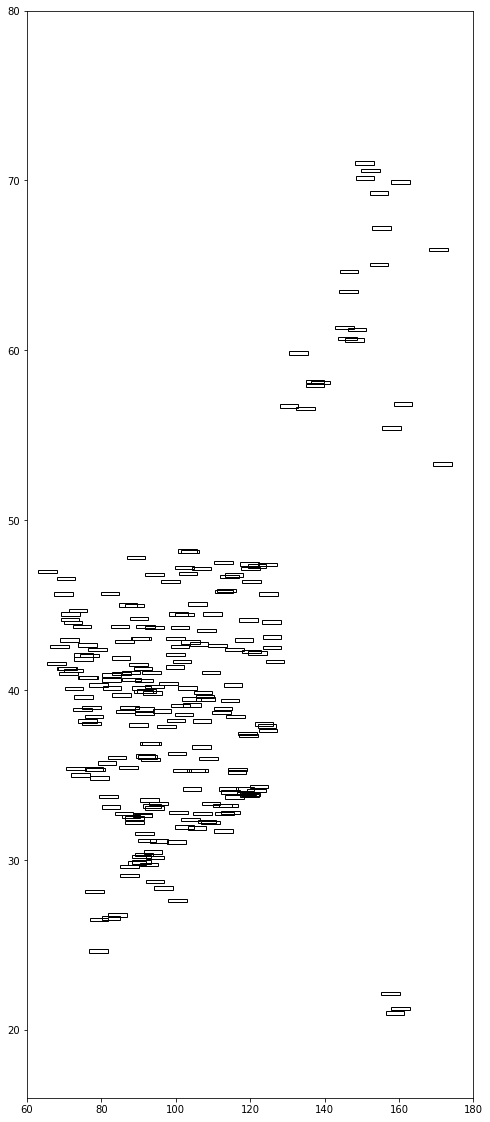

计算次数：10
tabu长度：56
循环次数：0计算次数：10
循环次数：0tabu长度：56
循环次数：50计算次数：5
循环次数：50tabu长度：31
循环次数：100计算次数：4
循环次数：100tabu长度：23
enter!
costfunc:165.1
循环次数：150计算次数：3
循环次数：150tabu长度：17
循环次数：200计算次数：3
循环次数：200tabu长度：18
循环次数：250计算次数：3
循环次数：250tabu长度：18
循环次数：300计算次数：3
循环次数：300tabu长度：17
循环次数：350计算次数：3
循环次数：350tabu长度：17
循环次数：400计算次数：3
循环次数：400tabu长度：18
enter!
costfunc:120.2
循环次数：450计算次数：3
循环次数：450tabu长度：17
enter!
costfunc:125.8
[[1, 4, 1], [2, 4, 0], [3, 4, 0], [4, 4, 0], [5, 2, 0], [6, 4, 0], [7, 4, 0], [8, 4, 0], [9, 4, 0], [10, 2, 1], [11, 4, 0], [12, 4, 0], [13, 4, 0], [14, 4, 0], [15, 1, 0], [16, 4, 0], [17, 2, 0], [18, 3, 1], [19, 4, 0], [20, 4, 0], [21, 3, 0], [22, 4, 1], [23, 3, 1], [24, 3, 1], [25, 3, 0], [26, 3, 0], [27, 4, 1], [28, 4, 0], [29, 2, 0], [30, 1, 0], [31, 3, 1], [32, 2, 0], [33, 3, 0], [34, 3, 0], [35, 3, 1], [36, 2, 0], [37, 4, 0], [38, 1, 0], [39, 4, 2], [40, 3, 0], [41, 2, 0], [42, 2, 0], [43, 4, 0], [44, 2, 0], [45, 3, 0], [46, 2, 0], [47, 3, 0], [48, 2, 0], [49, 4, 0], [50, 4, 0],

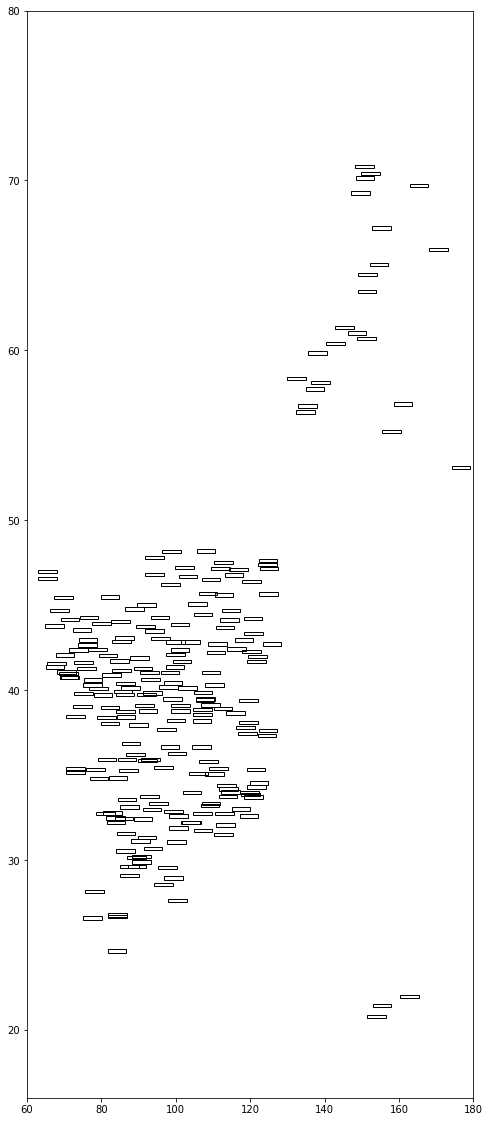

In [70]:
prepare_data(5)
test1_name1 = "500_10_10_231_random"
test1_name2 = "500_10_10_231_result"
a,b,c,d = tabusearch(iteration_times=500,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()

初始状态：
557.1


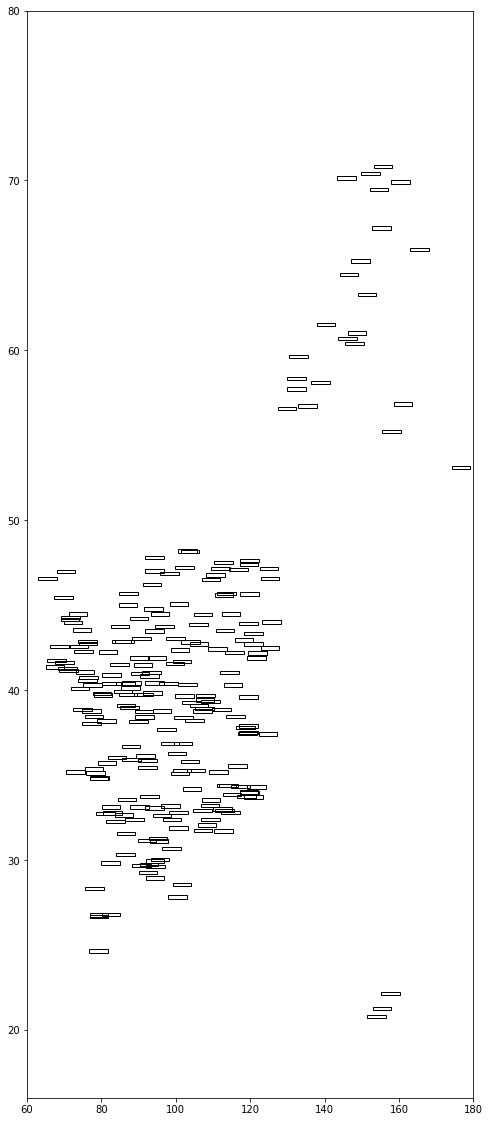

计算次数：9
tabu长度：48
循环次数：0计算次数：9
循环次数：0tabu长度：48
循环次数：50计算次数：5
循环次数：50tabu长度：28
循环次数：100计算次数：3
循环次数：100tabu长度：20
循环次数：150计算次数：3
循环次数：150tabu长度：19
循环次数：200计算次数：3
循环次数：200tabu长度：18
循环次数：250计算次数：3
循环次数：250tabu长度：18
循环次数：300计算次数：2
循环次数：300tabu长度：16
循环次数：350计算次数：3
循环次数：350tabu长度：20
循环次数：400计算次数：3
循环次数：400tabu长度：18
循环次数：450计算次数：3
循环次数：450tabu长度：18
循环次数：500计算次数：3
循环次数：500tabu长度：17
循环次数：550计算次数：3
循环次数：550tabu长度：17
循环次数：600计算次数：3
循环次数：600tabu长度：18
循环次数：650计算次数：3
循环次数：650tabu长度：18
循环次数：700计算次数：3
循环次数：700tabu长度：17
enter!
costfunc:119.8
enter!
costfunc:119.89999999999999
循环次数：750计算次数：3
循环次数：750tabu长度：17
enter!
costfunc:119.69999999999999
循环次数：800计算次数：3
循环次数：800tabu长度：18
循环次数：850计算次数：3
循环次数：850tabu长度：19
循环次数：900计算次数：3
循环次数：900tabu长度：17
循环次数：950计算次数：3
循环次数：950tabu长度：17
[[1, 4, 0], [2, 2, 0], [3, 3, 0], [4, 1, 0], [5, 4, 0], [6, 2, 0], [7, 4, 0], [8, 3, 1], [9, 3, 0], [10, 2, 0], [11, 2, 0], [12, 1, 0], [13, 3, 0], [14, 2, 0], [15, 1, 1], [16, 2, 1], [17, 3, 0], [18, 2, 1], [19, 4, 0], [20, 3, 0], [21, 

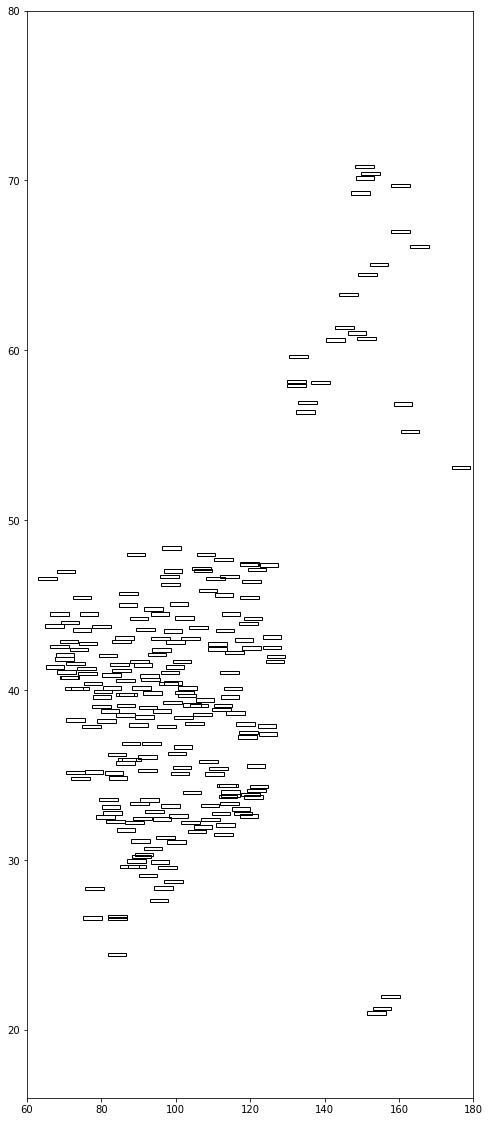

In [71]:
prepare_data(5)
test1_name1 = "1000_10_10_231_random"
test1_name2 = "1000_10_10_231_result"
a,b,c,d = tabusearch(iteration_times=1000,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()

初始状态：
920.7


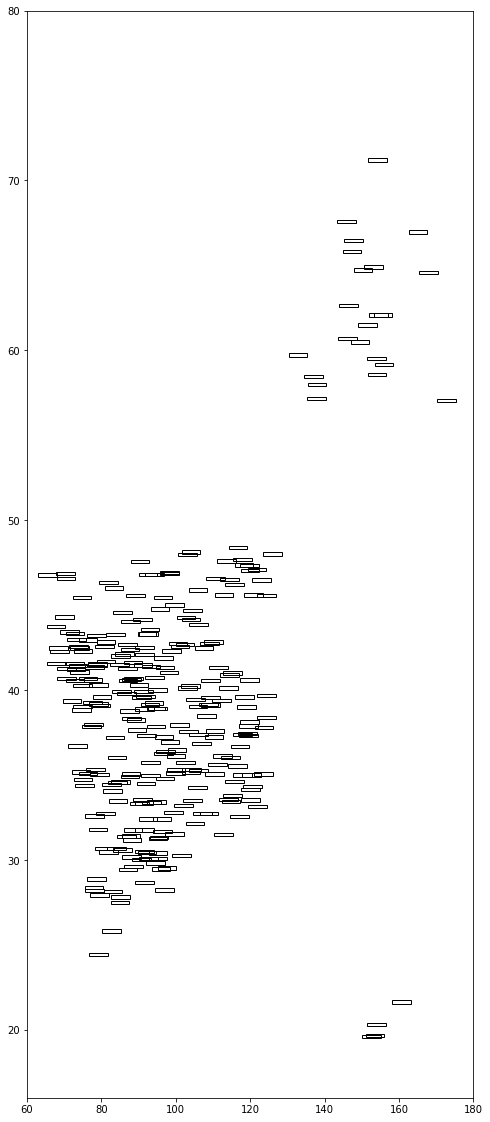

计算次数：15
tabu长度：77
循环次数：0计算次数：15
循环次数：0tabu长度：77
循环次数：50计算次数：8
循环次数：50tabu长度：45
循环次数：100计算次数：6
循环次数：100tabu长度：36
循环次数：150计算次数：6
循环次数：150tabu长度：32
enter!
costfunc:299.8
循环次数：200计算次数：5
循环次数：200tabu长度：31
enter!
costfunc:288.2
循环次数：250计算次数：5
循环次数：250tabu长度：28
循环次数：300计算次数：4
循环次数：300tabu长度：26
循环次数：350计算次数：4
循环次数：350tabu长度：26
循环次数：400计算次数：4
循环次数：400tabu长度：24
循环次数：450计算次数：4
循环次数：450tabu长度：26
enter!
[[1, 4, 1], [2, 3, 0], [3, 4, 1], [4, 1, 1], [5, 3, 1], [6, 3, 0], [7, 3, 1], [8, 2, 0], [9, 4, 0], [10, 3, 1], [11, 4, 0], [12, 3, 0], [13, 3, 0], [14, 4, 0], [15, 4, 0], [16, 3, 0], [17, 4, 0], [18, 1, 1], [19, 3, 0], [20, 3, 0], [21, 2, 0], [22, 2, 0], [23, 4, 0], [24, 2, 0], [25, 4, 0], [26, 4, 0], [27, 3, 0], [28, 4, 0], [29, 2, 2], [30, 3, 0], [31, 4, 0], [32, 4, 0], [33, 4, 0], [34, 2, 0], [35, 3, 0], [36, 2, 1], [37, 4, 0], [38, 4, 0], [39, 3, 0], [40, 1, 0], [41, 1, 0], [42, 2, 0], [43, 3, 0], [44, 4, 0], [45, 2, 0], [46, 4, 1], [47, 2, 2], [48, 3, 0], [49, 4, 0], [50, 1, 0], [51, 4, 1], [5

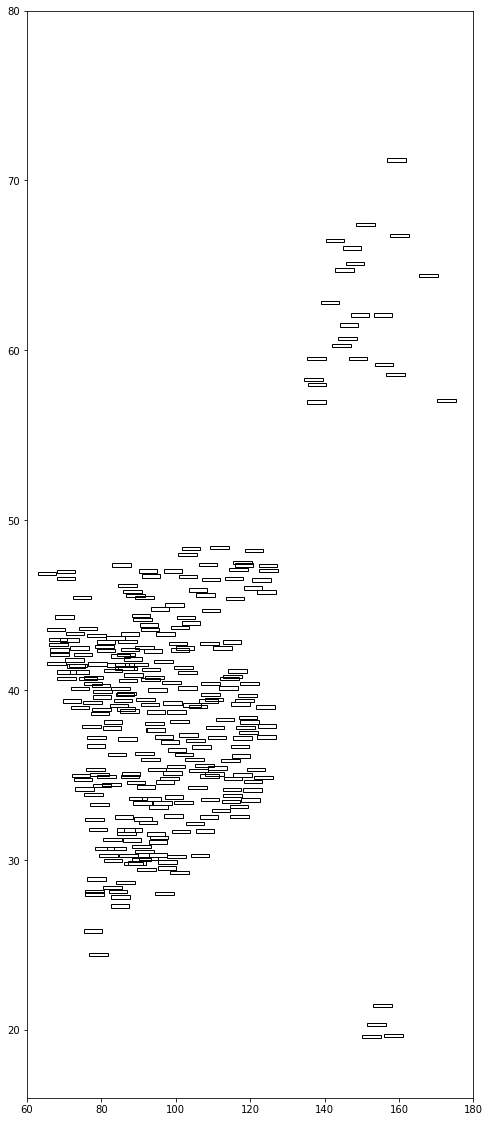

In [72]:
prepare_data(4)
test1_name1 = "500_10_10_289_random"
test1_name2 = "500_10_10_289_result"
a,b,c,d = tabusearch(iteration_times=500,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()

初始状态：
943.8


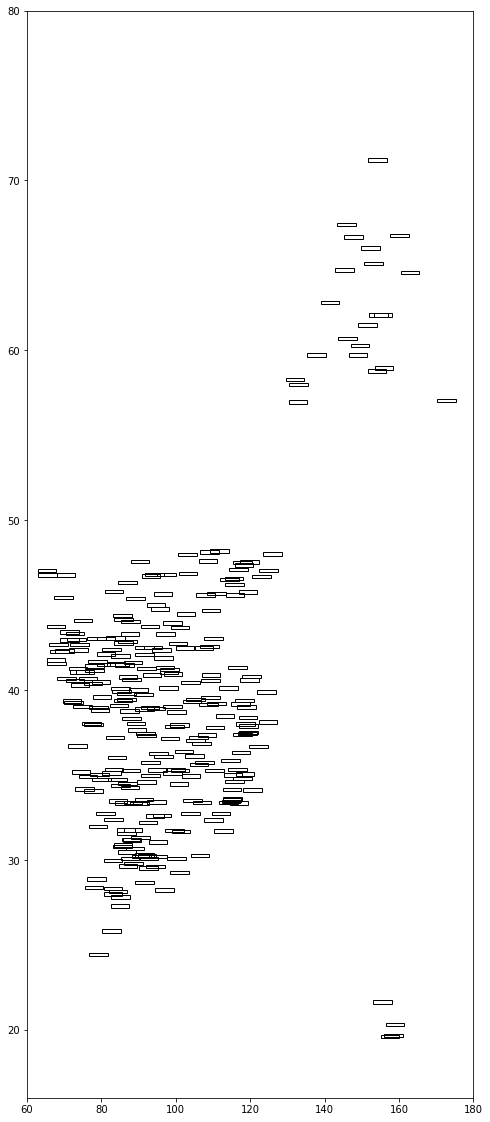

计算次数：15
tabu长度：79
循环次数：0计算次数：15
循环次数：0tabu长度：79
循环次数：50计算次数：8
循环次数：50tabu长度：44
循环次数：100计算次数：6
循环次数：100tabu长度：33
循环次数：150计算次数：5
循环次数：150tabu长度：27
循环次数：200计算次数：4
循环次数：200tabu长度：26
enter!
costfunc:230.89999999999998
循环次数：250计算次数：4
循环次数：250tabu长度：23
循环次数：300计算次数：4
循环次数：300tabu长度：24
循环次数：350计算次数：4
循环次数：350tabu长度：23
循环次数：400计算次数：3
循环次数：400tabu长度：21
循环次数：450计算次数：4
循环次数：450tabu长度：22
enter!
costfunc:176.79999999999998
循环次数：500计算次数：3
循环次数：500tabu长度：21
循环次数：550计算次数：4
循环次数：550tabu长度：26
循环次数：600计算次数：4
循环次数：600tabu长度：24
循环次数：650计算次数：4
循环次数：650tabu长度：25
循环次数：700计算次数：4
循环次数：700tabu长度：24
enter!
costfunc:207.20000000000002
循环次数：750计算次数：4
循环次数：750tabu长度：23
循环次数：800计算次数：4
循环次数：800tabu长度：23
循环次数：850计算次数：4
循环次数：850tabu长度：22
enter!
循环次数：900计算次数：4
循环次数：900tabu长度：24
循环次数：950计算次数：4
循环次数：950tabu长度：25
enter!
costfunc:207.1
[[1, 1, 1], [2, 3, 0], [3, 4, 0], [4, 1, 1], [5, 3, 1], [6, 2, 1], [7, 3, 0], [8, 3, 1], [9, 4, 0], [10, 3, 0], [11, 4, 0], [12, 2, 0], [13, 2, 0], [14, 1, 0], [15, 4, 0], [16, 2, 0], [17, 4, 0

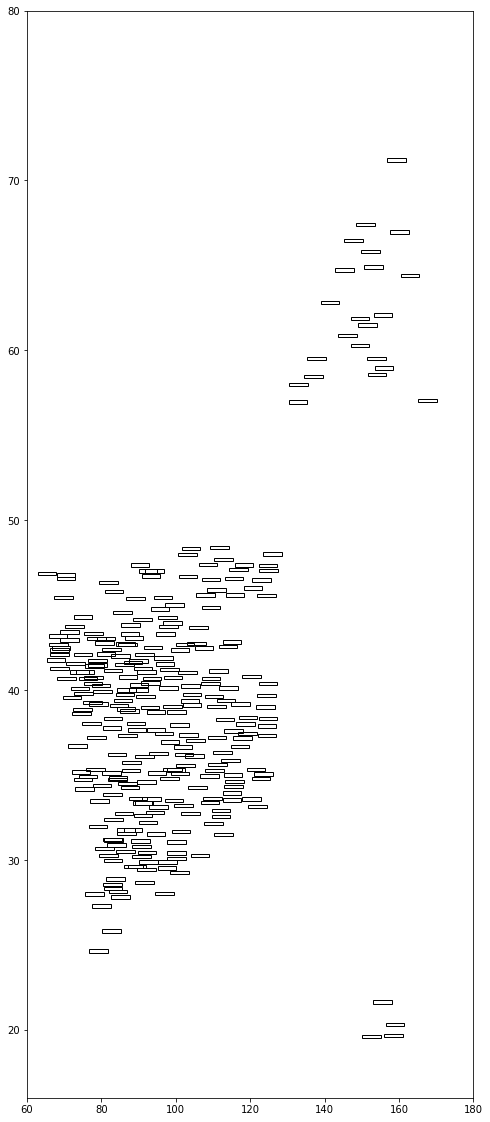

In [73]:
prepare_data(4)
test1_name1 = "1000_10_10_289_random"
test1_name2 = "1000_10_10_289_result"
a,b,c,d = tabusearch(iteration_times=1000,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()

初始状态：
1783.6


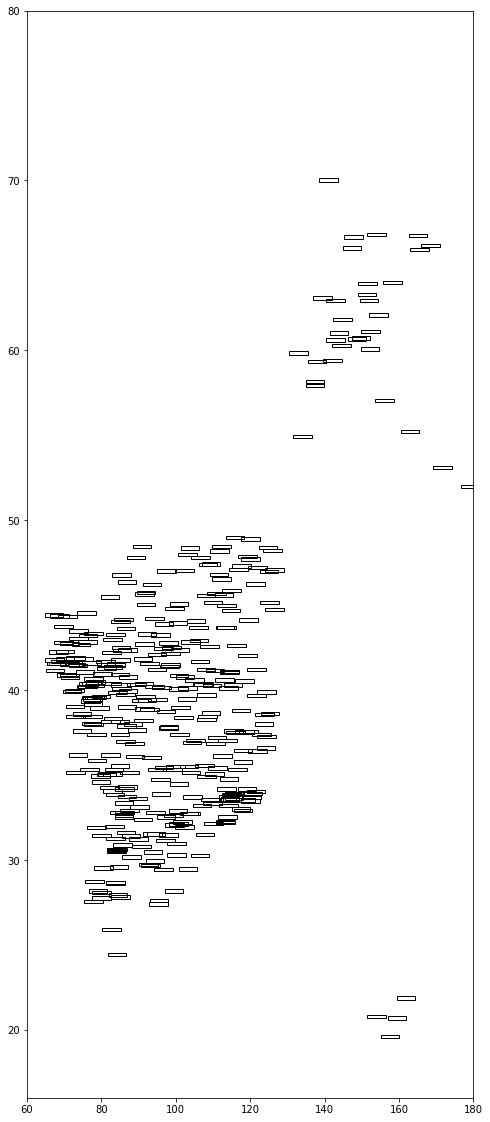

计算次数：29
tabu长度：147
循环次数：0计算次数：29
循环次数：0tabu长度：147
循环次数：50计算次数：19
循环次数：50tabu长度：99
循环次数：100计算次数：14
循环次数：100tabu长度：73
循环次数：150计算次数：11
循环次数：150tabu长度：58
循环次数：200计算次数：9
循环次数：200tabu长度：51
循环次数：250计算次数：9
循环次数：250tabu长度：48
enter!
costfunc:483.09999999999997
循环次数：300计算次数：8
循环次数：300tabu长度：45
enter!
costfunc:453.1
enter!
costfunc:452.9
循环次数：350计算次数：8
循环次数：350tabu长度：44
enter!
costfunc:441.1
enter!
costfunc:443.8
enter!
costfunc:444.09999999999997
enter!
costfunc:437.70000000000005
enter!
costfunc:437.90000000000003
enter!
costfunc:438.29999999999995
enter!
costfunc:434.9
循环次数：400计算次数：8
循环次数：400tabu长度：43
enter!
costfunc:428.70000000000005
enter!
costfunc:423.09999999999997
循环次数：450计算次数：7
循环次数：450tabu长度：40
[[1, 3, 0], [2, 3, 2], [3, 4, 0], [4, 2, 1], [5, 3, 0], [6, 4, 0], [7, 4, 2], [8, 4, 1], [9, 4, 0], [10, 3, 0], [11, 4, 0], [12, 4, 0], [13, 1, 0], [14, 4, 0], [15, 3, 0], [16, 3, 1], [17, 3, 0], [18, 4, 0], [19, 3, 0], [20, 4, 0], [21, 2, 0], [22, 2, 0], [23, 3, 0], [24, 4, 0], [25, 1, 0], [26, 

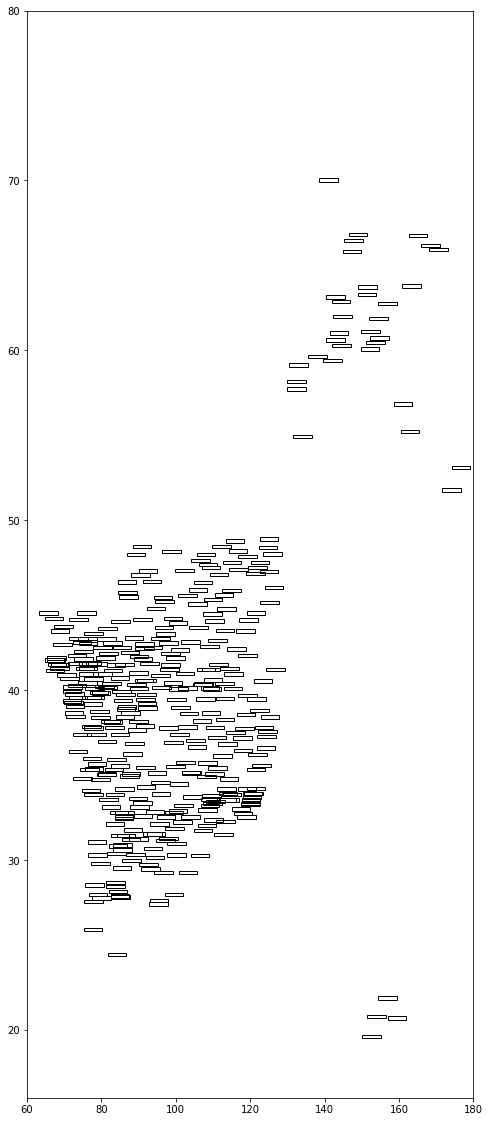

In [74]:
prepare_data(3)
test1_name1 = "500_10_10_386_random"
test1_name2 = "500_10_10_386_result"
a,b,c,d = tabusearch(iteration_times=500,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()

初始状态：
1707.6000000000001


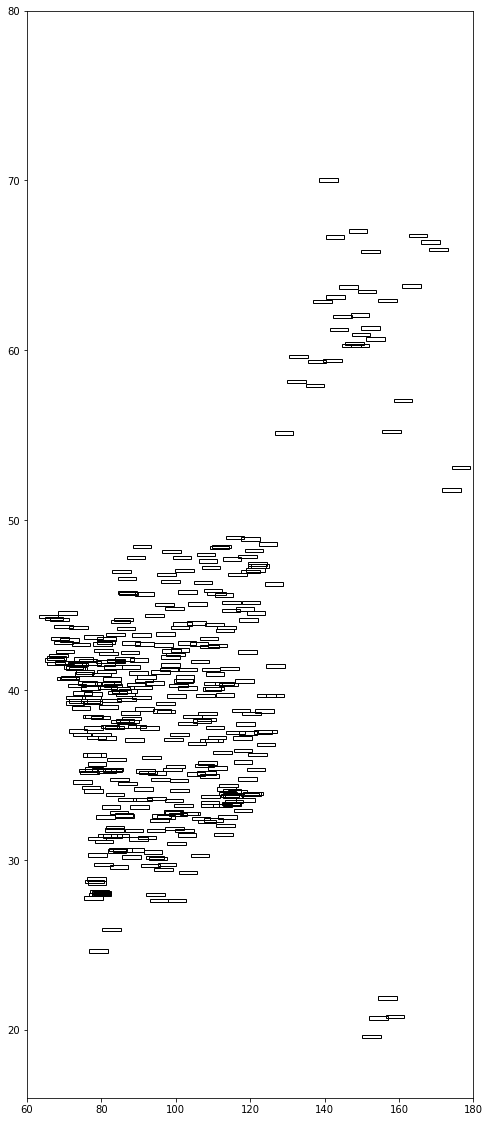

计算次数：27
tabu长度：141
循环次数：0计算次数：27
循环次数：0tabu长度：141
循环次数：50计算次数：17
循环次数：50tabu长度：89
循环次数：100计算次数：12
循环次数：100tabu长度：66
循环次数：150计算次数：10
循环次数：150tabu长度：56
循环次数：200计算次数：9
循环次数：200tabu长度：51
循环次数：250计算次数：9
循环次数：250tabu长度：48
enter!
costfunc:491.90000000000003
循环次数：300计算次数：8
循环次数：300tabu长度：46
enter!
costfunc:465.09999999999997
循环次数：350计算次数：8
循环次数：350tabu长度：43
enter!
costfunc:447.09999999999997
enter!
costfunc:443.90000000000003
循环次数：400计算次数：8
循环次数：400tabu长度：44
enter!
costfunc:441.09999999999997
enter!
costfunc:434.90000000000003
循环次数：450计算次数：8
循环次数：450tabu长度：42
循环次数：500计算次数：7
循环次数：500tabu长度：41
enter!
costfunc:411.09999999999997
循环次数：550计算次数：7
循环次数：550tabu长度：39
enter!
costfunc:387.1
循环次数：600计算次数：7
循环次数：600tabu长度：40
enter!
costfunc:384.09999999999997
循环次数：650计算次数：7
循环次数：650tabu长度：38
enter!
costfunc:369.09999999999997
循环次数：700计算次数：7
循环次数：700tabu长度：38
enter!
enter!
循环次数：750计算次数：7
循环次数：750tabu长度：38
enter!
enter!
循环次数：800计算次数：7
循环次数：800tabu长度：39
循环次数：850计算次数：7
循环次数：850tabu长度：40
循环次数：900计算次数：7
循环次数：900

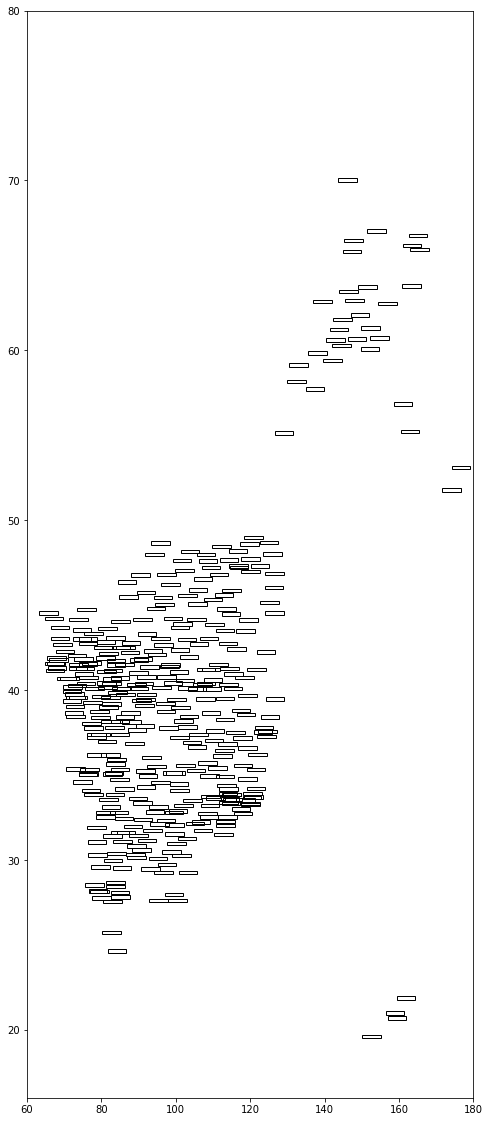

In [75]:
prepare_data(3)
test1_name1 = "1000_10_10_386_random"
test1_name2 = "1000_10_10_386_result"
a,b,c,d = tabusearch(iteration_times=1000,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()

初始状态：
3676.5


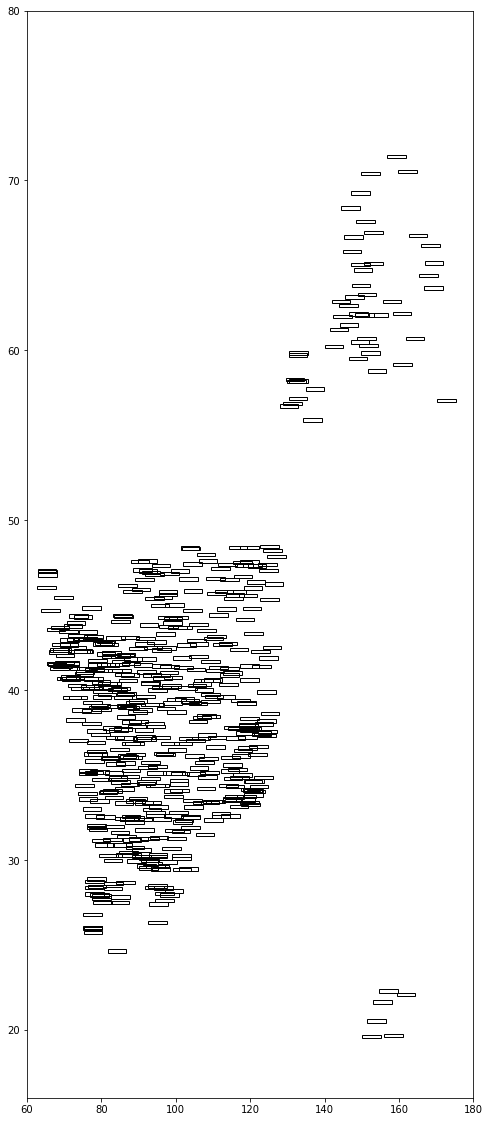

计算次数：59
tabu长度：301
循环次数：0计算次数：59
循环次数：0tabu长度：301
循环次数：50计算次数：44
循环次数：50tabu长度：224
循环次数：100计算次数：35
循环次数：100tabu长度：181
循环次数：150计算次数：30
循环次数：150tabu长度：152
循环次数：200计算次数：26
循环次数：200tabu长度：132
循环次数：250计算次数：23
循环次数：250tabu长度：121
循环次数：300计算次数：22
循环次数：300tabu长度：113
循环次数：350计算次数：21
循环次数：350tabu长度：107
循环次数：400计算次数：20
循环次数：400tabu长度：105
enter!
costfunc:1164.2
循环次数：450计算次数：20
循环次数：450tabu长度：102
enter!
costfunc:1130.8999999999999
循环次数：500计算次数：19
循环次数：500tabu长度：99
enter!
costfunc:1088.8999999999999
循环次数：550计算次数：18
循环次数：550tabu长度：96
enter!
costfunc:1067.9
enter!
costfunc:1068.1000000000001
enter!
costfunc:1067.8999999999999
enter!
costfunc:1068.1000000000001
enter!
costfunc:1068.1000000000001
enter!
costfunc:1065.1000000000001
循环次数：600计算次数：18
循环次数：600tabu长度：95
enter!
costfunc:1059.1000000000001
enter!
costfunc:1055.8999999999999
enter!
costfunc:1055.8999999999999
enter!
costfunc:1056.1000000000001
循环次数：650计算次数：18
循环次数：650tabu长度：94
enter!
costfunc:1044.1
enter!
costfunc:1044.1
enter!
costfunc:1040.899

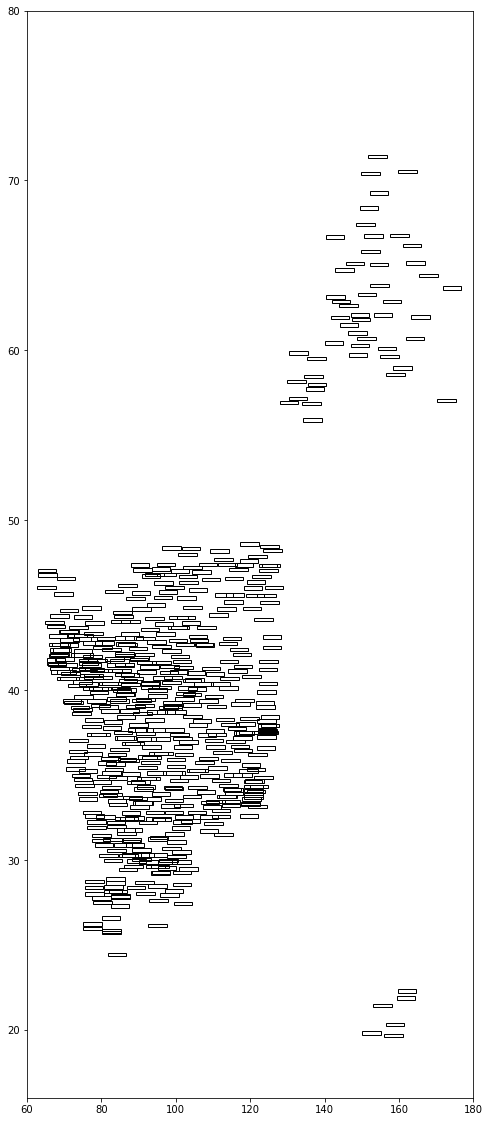

In [76]:
prepare_data(2)
test1_name1 = "1000_10_10_579_random"
test1_name2 = "1000_10_10_579_result"
a,b,c,d = tabusearch(iteration_times=1000,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()

初始状态：
3533.4


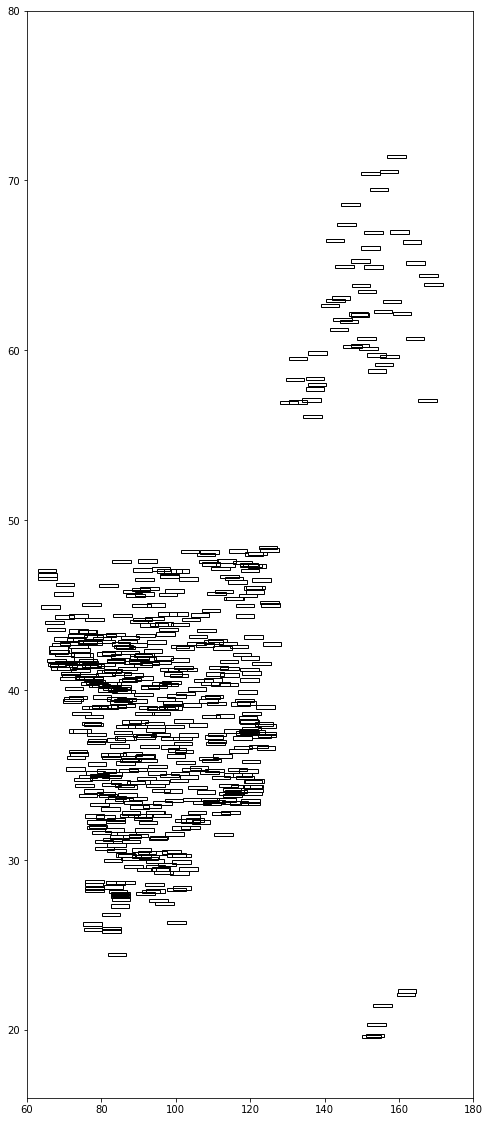

计算次数：57
tabu长度：289
循环次数：0计算次数：57
循环次数：0tabu长度：289
循环次数：50计算次数：42
循环次数：50tabu长度：215
循环次数：100计算次数：33
循环次数：100tabu长度：171
循环次数：150计算次数：28
循环次数：150tabu长度：144
循环次数：200计算次数：24
循环次数：200tabu长度：126
循环次数：250计算次数：22
循环次数：250tabu长度：115
循环次数：300计算次数：21
循环次数：300tabu长度：109
enter!
costfunc:1214.8999999999999
循环次数：350计算次数：20
循环次数：350tabu长度：106
enter!
costfunc:1169.8999999999999
循环次数：400计算次数：19
循环次数：400tabu长度：101
enter!
costfunc:1125.1
enter!
costfunc:1124.8999999999999
循环次数：450计算次数：19
循环次数：450tabu长度：98
enter!
costfunc:1095.1000000000001
enter!
costfunc:1094.8999999999999
enter!
costfunc:1094.9
enter!
costfunc:1086.1
[[1, 1, 1], [2, 1, 0], [3, 4, 1], [4, 3, 1], [5, 3, 2], [6, 4, 0], [7, 4, 0], [8, 1, 2], [9, 2, 0], [10, 3, 1], [11, 1, 0], [12, 1, 0], [13, 4, 2], [14, 2, 0], [15, 4, 0], [16, 2, 1], [17, 3, 1], [18, 4, 0], [19, 2, 1], [20, 3, 0], [21, 4, 0], [22, 1, 1], [23, 3, 0], [24, 3, 0], [25, 1, 1], [26, 3, 0], [27, 4, 0], [28, 1, 0], [29, 3, 1], [30, 3, 1], [31, 2, 0], [32, 4, 0], [33, 3, 3], [34, 4

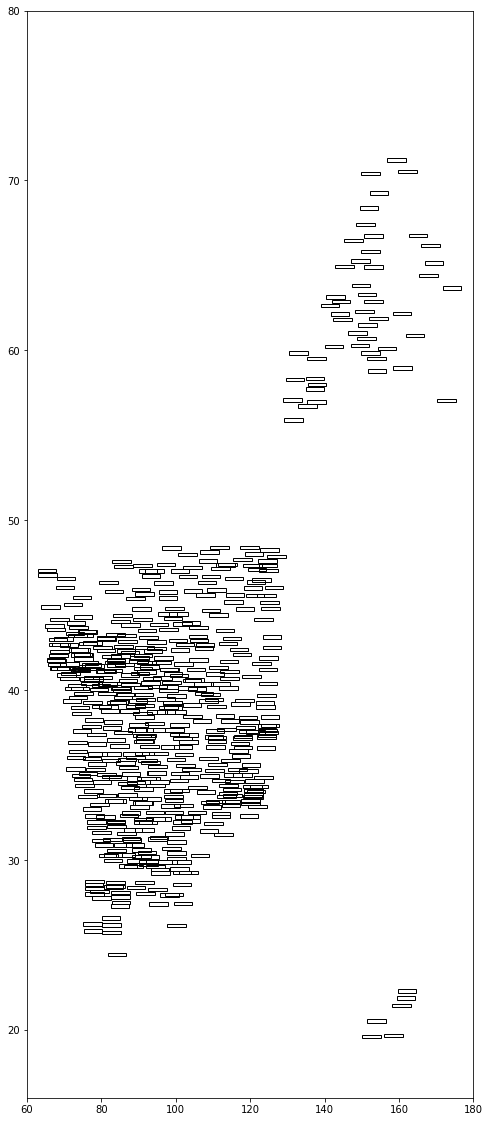

In [78]:
prepare_data(2)
test1_name1 = "500_10_10_579_random"
test1_name2 = "500_10_10_579_result"
a,b,c,d = tabusearch(iteration_times=500,cacu_time=10,tabu_length=10,origin_times=1,costf=costroad,printf=print,costflite=costrod_lite,namefortest=test1_name1)
# plt.plot(result_record)
# plt.show()
cc = costroad(a)
print(cc)
nameprefix = str(test1_name2) + str(cc)
plot(layout=a,name=nameprefix)
# plt.plot(result_record)
# plt.show()